In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
import sklearn

In [2]:
# DATA
df = pd.read_csv('C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv')

Tz  = np.array(df['room_temp']).reshape(-1,1)
Tsa = np.array(df['supply_discharge_temp']).reshape(-1,1)
msa = np.array(df['airflow_current']).reshape(-1,1)

n_train = 128

Tz_k   = Tz[0:n_train]
y      = Tz[1:n_train+1]
Tsa_k1 = Tsa[1:n_train+1]
msa_k1 = msa[1:n_train+1]
ones   = np.ones((n_train,1))

x0     = np.copy(Tz_k)
x1     = np.copy(Tsa_k1)
x2     = np.copy(msa_k1)
x02    = x0**2
x12    = x1**2
x22    = x2**2
x0x1   = x0*x1
x0x2   = x0*x2
x1x2   = x1*x2

x0_t = Tz[n_train:-1]
y_t  = Tz[n_train+1:]
x1_t = Tsa[n_train+1:]
x2_t = msa[n_train+1:]
ones_t = np.ones((Tz.shape[0]-n_train-1, 1))

A = np.concatenate((ones, x0, x1, x2, x02, x12, x22, x0x1, x0x2, x1x2), axis=1)
b = np.copy(y)

In [3]:
# SINDy with STLS
alpha = 0.0001
para = ()
A1 = np.copy(A)

while(1):
    c = np.linalg.lstsq(A1, b, rcond=-1)[0]
    c = c*(np.abs(c)>alpha)
    
    para = para + (c,)

    cols = np.array([], dtype=np.int32)
    for i in range(c.shape[0]):
        if c[i] == 0:
            cols = np.append(cols, i)
    if(cols.shape[0] == 0): break
    A1 = np.delete(A1, cols, axis=1)

In [4]:
# STLS
def transfer(long, short):
    cols = np.where(long != 0)[0]
    out = np.copy(long)
    for i, c in enumerate(cols):
        out[c] = short[i]
    return out

def convert(para):
    c = para[len(para)-1]
    for i in range(len(para)-1):
        c = transfer(para[len(para) - 2 - i], c)
    return c

c = convert(para)

m = np.array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).reshape(10,1)
def relu(x):
    return (x>0)*x

c = c + relu(-c*m)

In [5]:
# SINDy with STLS
alpha = 0.0001
para = ()
A1 = np.copy(A)

while(1):
    para = para + (c,)

    cols = np.array([], dtype=np.int32)
    for i in range(c.shape[0]):
        if c[i] == 0:
            cols = np.append(cols, i)
    if(cols.shape[0] == 0): break
    A1 = np.delete(A1, cols, axis=1)
    
    c = np.linalg.lstsq(A1, b, rcond=-1)[0]
    c = c*(np.abs(c)>alpha)

c = convert(para)

print("Number of terms:", np.sum((c!=0)))
print(c)

Number of terms: 6
[[-3.34037361e+01]
 [ 1.81517373e+00]
 [ 1.37962596e-01]
 [ 3.66246967e-04]
 [-4.89882543e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.93858801e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


In [6]:
# System
def system(one, x0, x1, x2):
    return c[0]*one + c[1]*x0 + c[2]*x1 + c[3]*x2 + \
           c[4]*x0**2 + c[5]*x1**2 + c[6]*x2**2 + c[7]*x0*x1 + c[8]*x0*x2 + c[9]*x1*x2

RMSE: 0.06899466159410632
R2:   0.9984284238392208


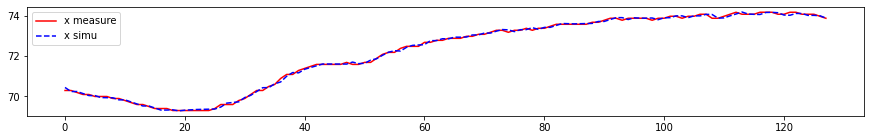

In [7]:
x_simu = system(ones, x0, x1, x2)
print("RMSE:", np.sqrt(np.mean(np.square(x_simu - y))))
print("R2:  ", sklearn.metrics.r2_score(y, x_simu))

# plot
plt.figure(figsize=(15,2))
plt.plot(y,      'r-',  label='x measure')
plt.plot(x_simu, 'b--', label='x simu')
plt.legend()
plt.show()

RMSE: 0.08388950616609016
R2:   0.9979317729198605


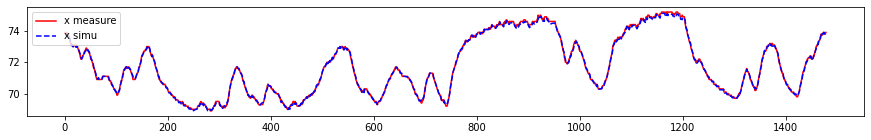

In [8]:
x_simu = system(ones_t, x0_t, x1_t, x2_t)
print("RMSE:", np.sqrt(np.mean(np.square(x_simu - y_t))))
print("R2:  ", sklearn.metrics.r2_score(y_t, x_simu))

# plot
plt.figure(figsize=(15,2))
plt.plot(y_t,    'r-',  label='x measure')
plt.plot(x_simu, 'b--', label='x simu')
plt.legend()
plt.show()